In [67]:
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler
import numpy as np
import re
import warnings
import os

In [70]:
os.getcwd()

'/home/jnear/co/code/choreography/graphs'

In [108]:
plt.rcParams["figure.figsize"] = (5,3)

In [109]:
df = pd.concat((pd.read_csv('../gitignore/circuit_results/demo_16-10-2023_20:48:38.csv'),
                pd.read_csv('../gitignore/circuit_results/demo_16-10-2023_19:35:17.csv')))

In [110]:
df = pd.read_csv('/home/jnear/co/code/choreography/results/circuit_results_26-10-2023_16:28:06.csv')

In [111]:
df.head()

,circuit,protocol,iters,train_size,test_size,pval,data_time,d_tree_time,bias_sharing,bias_and,accidental_secret,accidental_gate,outputs
0,adder_1.txt,gmw,128,1024,512,0.5,1.71,5.32,0,0,0,0,values
1,adder_1.txt,gmw,128,1024,512,0.5,1.92,5.17,0,0,0,0,values
2,adder_1.txt,gmw,128,1024,512,0.5,1.54,5.12,0,0,0,0,values
3,adder_1.txt,gmw,128,2048,1024,0.5,1.95,4.35,0,0,0,0,values
4,adder_1.txt,gmw,128,2048,1024,0.5,2.20,5.35,0,0,0,0,values


In [112]:
df.circuit.unique()

array(['adder_1.txt', 'beaver_triple_gen_1.txt', 'less_than_1.txt',
       'adder_2.txt', 'beaver_triple_gen_2.txt', 'less_than_2.txt',
       'adder_3.txt', 'beaver_triple_gen_3.txt', 'less_than_3.txt',
       'adder_6.txt', 'beaver_triple_gen_6.txt', 'less_than_6.txt',
       'adder_9.txt', 'beaver_triple_gen_9.txt', 'less_than_9.txt',
       'adder_12.txt', 'beaver_triple_gen_12.txt', 'less_than_12.txt',
       'adder_16.txt', 'beaver_triple_gen_16.txt', 'less_than_16.txt',
       'adder_20.txt', 'beaver_triple_gen_20.txt', 'less_than_20.txt',
       'adder_24.txt', 'beaver_triple_gen_24.txt', 'less_than_24.txt',
       'adder_32.txt', 'beaver_triple_gen_32.txt', 'less_than_32.txt'],
      dtype=object)

# Fixing Test Power, Graphing P-Values

In [113]:
iters_vals = df['iters'].unique()
train_size_vals = df['train_size'].unique()
test_size_vals = df['test_size'].unique()
iters_vals

array([128, 256])

In [114]:
iters = 128
train_size = 1024
test_size = 512
protocol = 'gmw'

def make_graph(iters=128, train_size=512, test_size=256, protocol='gmw', circuit='adder'):
    _make_graph(iters, train_size, test_size, protocol, circuit)

def _make_graph(iters=128, train_size=512, test_size=256, protocol='gmw', circuit='adder'):
    adders = {n: f'{circuit}_{n}.txt' for n in range(1, 33)}
    adders_set = set(list(adders.values()))
    replace = {v: k for k, v in adders.items()}

    df_graph = df[(df['iters'] == iters) & (df['train_size'] == train_size) & (df['test_size'] == test_size) & 
                  (df['protocol'] == protocol) & (df['circuit'].isin(adders_set))]
    df_graph['circuit_num'] = df_graph['circuit'].apply(lambda x: replace[x])

    df_g = df_graph.groupby('circuit_num')

    means = df_g['pval'].mean()
    stds = df_g['pval'].std()

    def get_broken(df, b1, b2, b3, b4):
        return df[(df['bias_sharing'] == b1) & (df['bias_and'] == b2) & 
                  (df['accidental_secret'] == b3) & (df['accidental_gate'] == b4)]

    results = {'Secure': get_broken(df_graph, 0, 0, 0, 0),
               'Biased Sharing': get_broken(df_graph, 1, 0, 0, 0),
               #'Biased Sharing (2)': get_broken(df_graph, 2, 0, 0, 0),
               'Biased AND': get_broken(df_graph, 0, 1, 0, 0),
               #'Biased AND (2)': get_broken(df_graph, 0, 2, 0, 0),
               #'Accidental Secret Send (1/4)': get_broken(df_graph, 0, 0, 1/4, 0),
               #'Accidental Gate Send (1/4)': get_broken(df_graph, 0, 0, 0, 1/4),
               'Accidental Secret': get_broken(df_graph, 0, 0, 1/2, 0),
               'Accidental Gate': get_broken(df_graph, 0, 0, 0, 1/2),
              }

    ls_cycler = cycler('linestyle',
                       ['-','--',':','-.',(0, (5, 1)),(0, (3, 1, 1, 1, 1, 1)), (0, (3, 5, 1, 5)), (0, (3, 1, 1, 1, 1, 1))])
    color_cycler = cycler('color', 'rgbmykcr') #bgrcmyk | 
    marker ='.'
    marker_cycler = cycler('marker', ['', 'x','*', '>', 'p', 's','.','>']) #, '.'])

    new_cycler = color_cycler + ls_cycler + marker_cycler

    plt.rcParams['axes.prop_cycle'] = new_cycler
    for k, v in results.items():
        df_g = v.groupby('circuit_num')
        means = df_g['pval'].mean()
        #print(means)
        stds = df_g['pval'].std()

        x = means.index
        y = means
        error = stds
        plt.plot(x, y,label=k, linewidth=5, markersize=10)
        plt.fill_between(x, y-error, y+error, alpha=.25, linewidth=0)

    plt.legend()
    plt.ylabel('Mean p-value')
    plt.xlabel('Bitwidth')
    plt.tight_layout()
    plt.savefig(f'../paper/graphs/security_{circuit}_{protocol}_{iters}_{train_size}.pdf')
    plt.show()


# 64 Iters, GMW

EXPERIMENT: adder gmw 128


/tmp/ipykernel_2169287/1873804191.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph['circuit_num'] = df_graph['circuit'].apply(lambda x: replace[x])


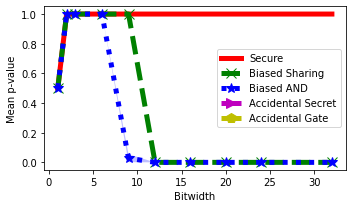

/tmp/ipykernel_2169287/1873804191.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph['circuit_num'] = df_graph['circuit'].apply(lambda x: replace[x])


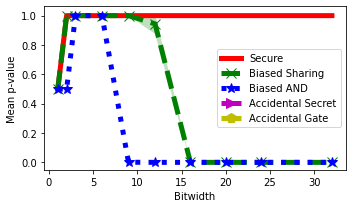

EXPERIMENT: adder gmw 256


/tmp/ipykernel_2169287/1873804191.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph['circuit_num'] = df_graph['circuit'].apply(lambda x: replace[x])


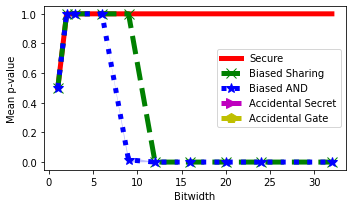

/tmp/ipykernel_2169287/1873804191.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph['circuit_num'] = df_graph['circuit'].apply(lambda x: replace[x])


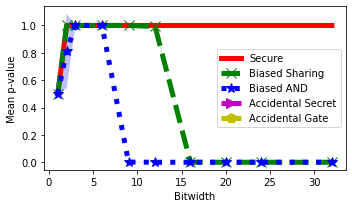

EXPERIMENT: adder beaver 128


/tmp/ipykernel_2169287/1873804191.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph['circuit_num'] = df_graph['circuit'].apply(lambda x: replace[x])


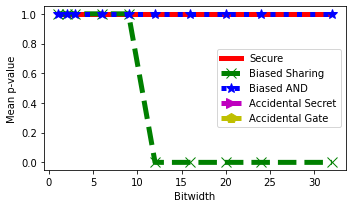

/tmp/ipykernel_2169287/1873804191.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph['circuit_num'] = df_graph['circuit'].apply(lambda x: replace[x])


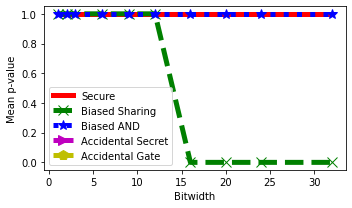

EXPERIMENT: adder beaver 256


/tmp/ipykernel_2169287/1873804191.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph['circuit_num'] = df_graph['circuit'].apply(lambda x: replace[x])


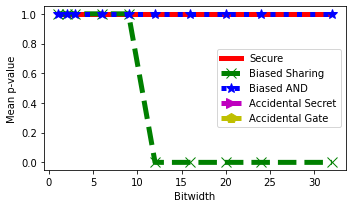

/tmp/ipykernel_2169287/1873804191.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph['circuit_num'] = df_graph['circuit'].apply(lambda x: replace[x])


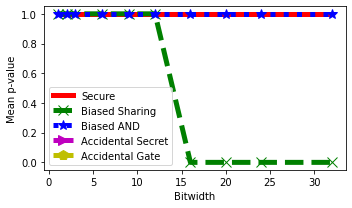

EXPERIMENT: beaver_triple_gen gmw 128


/tmp/ipykernel_2169287/1873804191.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph['circuit_num'] = df_graph['circuit'].apply(lambda x: replace[x])


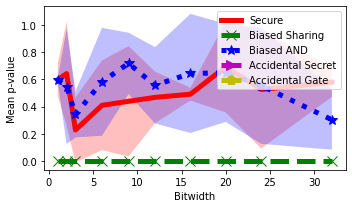

/tmp/ipykernel_2169287/1873804191.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph['circuit_num'] = df_graph['circuit'].apply(lambda x: replace[x])


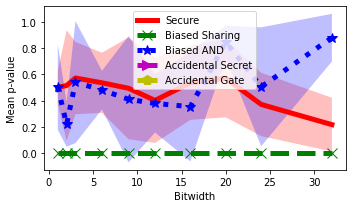

EXPERIMENT: beaver_triple_gen gmw 256


/tmp/ipykernel_2169287/1873804191.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph['circuit_num'] = df_graph['circuit'].apply(lambda x: replace[x])


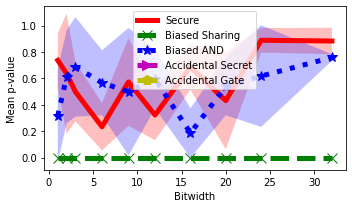

/tmp/ipykernel_2169287/1873804191.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph['circuit_num'] = df_graph['circuit'].apply(lambda x: replace[x])


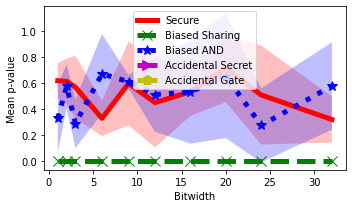

EXPERIMENT: beaver_triple_gen beaver 128


/tmp/ipykernel_2169287/1873804191.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph['circuit_num'] = df_graph['circuit'].apply(lambda x: replace[x])


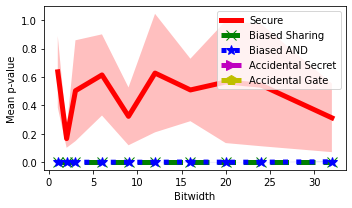

/tmp/ipykernel_2169287/1873804191.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph['circuit_num'] = df_graph['circuit'].apply(lambda x: replace[x])


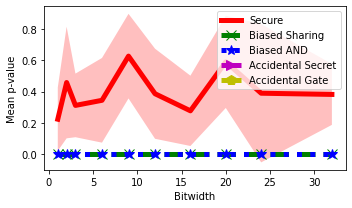

EXPERIMENT: beaver_triple_gen beaver 256


/tmp/ipykernel_2169287/1873804191.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph['circuit_num'] = df_graph['circuit'].apply(lambda x: replace[x])


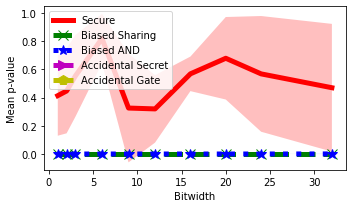

/tmp/ipykernel_2169287/1873804191.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph['circuit_num'] = df_graph['circuit'].apply(lambda x: replace[x])


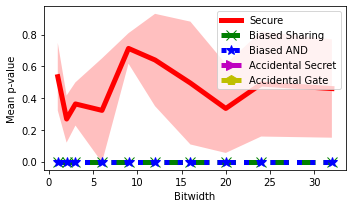

EXPERIMENT: less_than gmw 128


/tmp/ipykernel_2169287/1873804191.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph['circuit_num'] = df_graph['circuit'].apply(lambda x: replace[x])


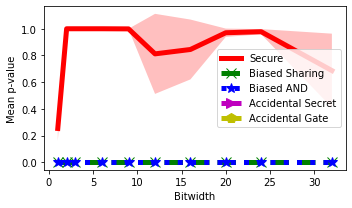

/tmp/ipykernel_2169287/1873804191.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph['circuit_num'] = df_graph['circuit'].apply(lambda x: replace[x])


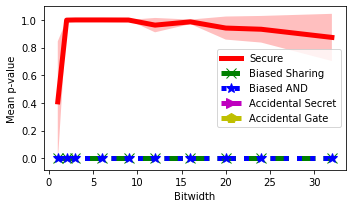

EXPERIMENT: less_than gmw 256


/tmp/ipykernel_2169287/1873804191.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph['circuit_num'] = df_graph['circuit'].apply(lambda x: replace[x])


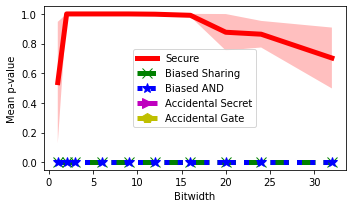

/tmp/ipykernel_2169287/1873804191.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph['circuit_num'] = df_graph['circuit'].apply(lambda x: replace[x])


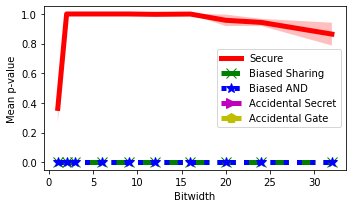

EXPERIMENT: less_than beaver 128


/tmp/ipykernel_2169287/1873804191.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph['circuit_num'] = df_graph['circuit'].apply(lambda x: replace[x])


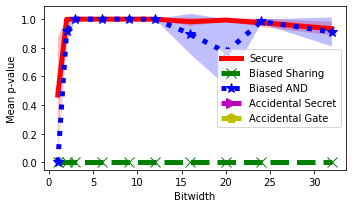

/tmp/ipykernel_2169287/1873804191.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph['circuit_num'] = df_graph['circuit'].apply(lambda x: replace[x])


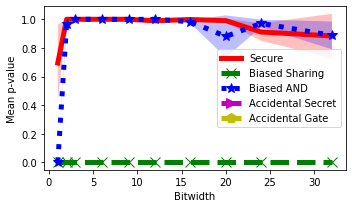

EXPERIMENT: less_than beaver 256


/tmp/ipykernel_2169287/1873804191.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph['circuit_num'] = df_graph['circuit'].apply(lambda x: replace[x])


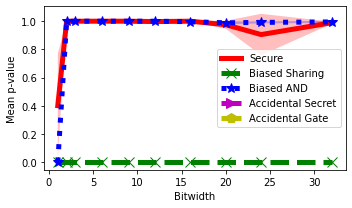

/tmp/ipykernel_2169287/1873804191.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph['circuit_num'] = df_graph['circuit'].apply(lambda x: replace[x])


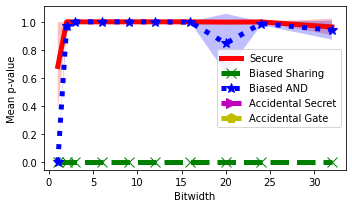

In [115]:
for circuit in ['adder', 'beaver_triple_gen', 'less_than']:
    for protocol in ['gmw', 'beaver']:
        for iters in iters_vals:
            print("EXPERIMENT:", circuit, protocol, iters)
            for train_size in train_size_vals:
                test_size=train_size/2
                make_graph(iters, train_size, test_size, protocol, circuit)

# Analysis Time

In [116]:
def make_time_graph(time_col, protocol='gmw', circuit='adder'):
    adders = {n: f'{circuit}_{n}.txt' for n in range(1, 33)}
    adders_set = set(list(adders.values()))
    replace = {v: k for k, v in adders.items()}

    df_graph = df[(df['circuit'].isin(adders_set))]
    df_graph['circuit_num'] = df_graph['circuit'].apply(lambda x: replace[x])

    def get_df(df, iters, train_size, protocol):
        test_size = train_size / 2
        return df[(df['iters'] == iters) & (df['train_size'] == train_size) & (df['test_size'] == test_size) & 
                  (df['protocol'] == protocol) & 
                  (df['bias_sharing'] == 0) & (df['bias_and'] == 0) & 
                  (df['accidental_secret'] == 0) & (df['accidental_gate'] == 0)]
    results = {}
    for protocol in [protocol]:
        for iters in iters_vals:
            for train_size in train_size_vals:
                r = get_df(df_graph, iters, train_size, protocol)
                results[f'Iterations = {iters}, Training Size = {train_size}'] = r
    ls_cycler = cycler('linestyle',
                       ['-','--',':','-.',(0, (5, 1)),(0, (3, 1, 1, 1, 1, 1)), (0, (3, 5, 1, 5)), (0, (3, 1, 1, 1, 1, 1))])
    color_cycler = cycler('color', 'rgbmykcr') #bgrcmyk | 
    marker ='.'
    marker_cycler = cycler('marker', ['', 'x','*', '>', 'p', 's','.','>']) #, '.'])

    new_cycler = color_cycler + ls_cycler + marker_cycler

    plt.rcParams['axes.prop_cycle'] = new_cycler
    for k, v in results.items():
        df_g = v.groupby('circuit_num')
        means = df_g[time_col].mean()
        #print(means)
        stds = df_g[time_col].std()

        x = means.index
        y = means
        error = stds
        plt.plot(x, y,label=k, linewidth=5, markersize=10)
        plt.fill_between(x, y-error, y+error, alpha=.25, linewidth=0)

    plt.legend()
    plt.ylabel('Decision Tree Training Time (s)')
    plt.xlabel('Bitwidth')
    plt.tight_layout()
    plt.savefig(f'../paper/graphs/time_{circuit}_{protocol}_{iters}_{train_size}.pdf')
    plt.show()

EXPERIMENT: adder gmw


/tmp/ipykernel_2169287/3289354153.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph['circuit_num'] = df_graph['circuit'].apply(lambda x: replace[x])


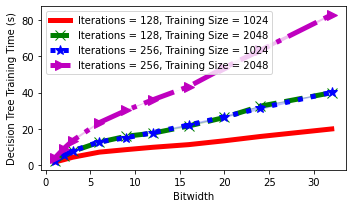

EXPERIMENT: adder beaver


/tmp/ipykernel_2169287/3289354153.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph['circuit_num'] = df_graph['circuit'].apply(lambda x: replace[x])


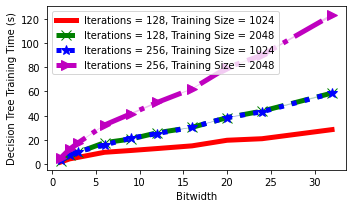

EXPERIMENT: beaver_triple_gen gmw


/tmp/ipykernel_2169287/3289354153.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph['circuit_num'] = df_graph['circuit'].apply(lambda x: replace[x])


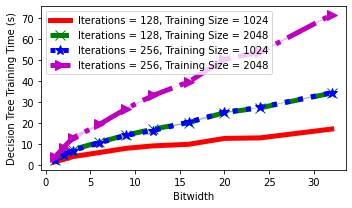

EXPERIMENT: beaver_triple_gen beaver


/tmp/ipykernel_2169287/3289354153.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph['circuit_num'] = df_graph['circuit'].apply(lambda x: replace[x])


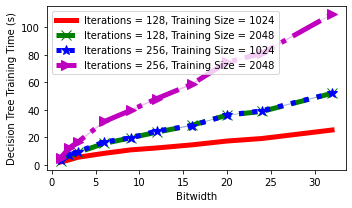

EXPERIMENT: less_than gmw


/tmp/ipykernel_2169287/3289354153.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph['circuit_num'] = df_graph['circuit'].apply(lambda x: replace[x])


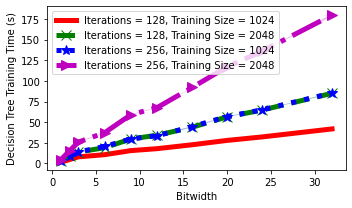

EXPERIMENT: less_than beaver


/tmp/ipykernel_2169287/3289354153.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph['circuit_num'] = df_graph['circuit'].apply(lambda x: replace[x])


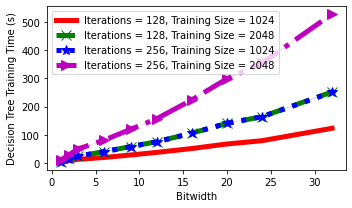

In [117]:
for circuit in ['adder', 'beaver_triple_gen', 'less_than']:
    for protocol in ['gmw', 'beaver']:
        print("EXPERIMENT:", circuit, protocol)
        make_time_graph('data_time', protocol, circuit)